In [122]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import zipfile
import shutil
import gdown


# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# Нормирование сигнала
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline


from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Headliner.csv

In [123]:
gdown.download('https://drive.google.com/uc?export=download&id=18IIGdieFoL8IQAiyo_TBEVSyr1AhiuGT')

Downloading...
From: https://drive.google.com/uc?export=download&id=18IIGdieFoL8IQAiyo_TBEVSyr1AhiuGT
To: /content/Headliner.csv
100%|██████████| 3.67M/3.67M [00:00<00:00, 118MB/s]


'Headliner.csv'

In [124]:
csv_file = 'Headliner.csv'
# data = pd.read_csv(csv_file, sep=';', header = 4)
# data

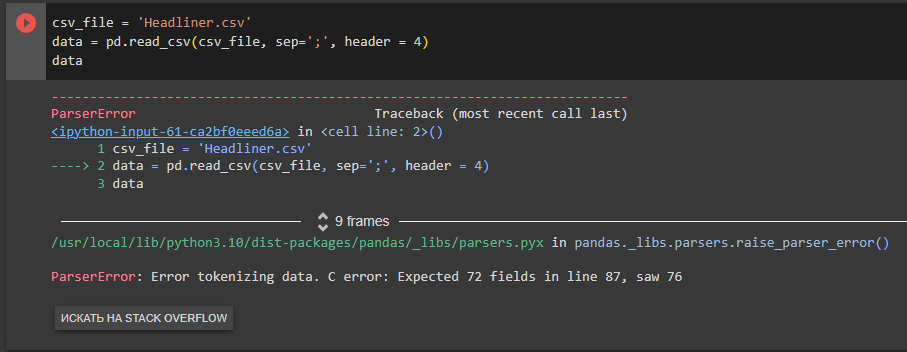

Ошибка происходит из-за того, что в базе присуствуют подобные выбросы (фото ниже).


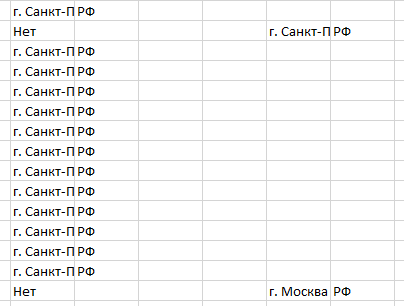

In [125]:
# Обнаружем все выбросы и удостоверимся, что они одной природы (как на фотографии выше)
df = pd.read_csv('Headliner.csv', delimiter=';', on_bad_lines='warn', header = 5)

Skipping line 87: expected 72 fields, saw 76
Skipping line 436: expected 72 fields, saw 76
Skipping line 622: expected 72 fields, saw 76
Skipping line 1770: expected 72 fields, saw 76
Skipping line 1783: expected 72 fields, saw 76
Skipping line 2110: expected 72 fields, saw 76
Skipping line 4605: expected 72 fields, saw 76



In [126]:
# Создание нового файла без выбросов
csv_file_without_outlier = 'Headliner_without_outlier.csv'

In [127]:
# Записывание базы в новый фйал с исправлениями
with open(csv_file, 'r') as data:
    with open(csv_file_without_outlier, 'w') as new_data:
        for n, string in enumerate(data):
            list_string = string.split(';')
            if len(list_string) == 76: # Поиск выброса
                print(f'Database Outlier in line {n + 1}: {list_string[69:]}')
                list_string = list_string[:-7] + list_string[-3:] # Исправление выброса за счет "вырезания" ненужного интервала
                print(f"Changed to {list_string[69:]} with new lenght {len(list_string)}\n")
            new_data.write(';'.join(list_string))

Database Outlier in line 87: ['Нет', '', '', '', 'Пермский край', 'РФ', '\n']
Changed to ['Пермский край', 'РФ', '\n'] with new lenght 72

Database Outlier in line 436: ['Нет', '', '', '', 'г. Москва', 'РФ', '\n']
Changed to ['г. Москва', 'РФ', '\n'] with new lenght 72

Database Outlier in line 622: ['Нет', '', '', '', 'г. Москва', 'РФ', '\n']
Changed to ['г. Москва', 'РФ', '\n'] with new lenght 72

Database Outlier in line 1770: ['Нет', '', '', '', 'г. Санкт-Петербург', 'РФ', '\n']
Changed to ['г. Санкт-Петербург', 'РФ', '\n'] with new lenght 72

Database Outlier in line 1783: ['Нет', '', '', '', 'г. Москва', 'РФ', '\n']
Changed to ['г. Москва', 'РФ', '\n'] with new lenght 72

Database Outlier in line 2110: ['Нет', '', '', '', 'г. Москва', 'РФ', '\n']
Changed to ['г. Москва', 'РФ', '\n'] with new lenght 72

Database Outlier in line 4605: ['Нет', '', '', '', 'Республика Башкортостан', 'РФ', '\n']
Changed to ['Республика Башкортостан', 'РФ', '\n'] with new lenght 72



In [128]:
df = pd.read_csv(csv_file_without_outlier, delimiter=';', header=4)
df

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Домен реферера,Сайт,Оценка сотрудника,Внутренний звонок,ФИО контакта,Имя тренера,"Группа, выбранная посетителем",Регион номера абонента,Страна номера абонента,Контакт из CRM
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,г. Москва,РФ,NaN
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,РФ / не определено,РФ,NaN
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,г. Москва,РФ,NaN
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,г. Москва,РФ,NaN
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,suggest.sso.dzen.ru,head-liner.ru,NaN,Нет,NaN,NaN,NaN,г. Москва,РФ,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,head-liner.ru,head-liner.ru,NaN,Нет,NaN,NaN,NaN,РФ / не определено,РФ,NaN
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,Республика Чувашия,РФ,NaN
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,away.vk.com,head-liner.ru,NaN,Нет,NaN,NaN,NaN,Российская Федерация 8-800,РФ,NaN
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,head-liner.ru,NaN,Нет,NaN,NaN,NaN,г. Москва,РФ,NaN


Продолжим "причесывание" датафрейма

In [129]:
df.shape

(4759, 72)

In [130]:
# Подсчет непустых записей в каждом столбце
df.count().head(72)

Статус                           4759
Тип                              4759
Дата и время                     4759
Номер абонента                   4758
Виртуальный номер                4759
                                 ... 
Имя тренера                         7
Группа, выбранная посетителем       0
Регион номера абонента           4630
Страна номера абонента           4630
Контакт из CRM                      0
Length: 72, dtype: int64

In [131]:
# Типы данных столбцов датафрейма
df.dtypes.head(72)

Статус                            object
Тип                               object
Дата и время                      object
Номер абонента                   float64
Виртуальный номер                  int64
                                  ...   
Имя тренера                       object
Группа, выбранная посетителем    float64
Регион номера абонента            object
Страна номера абонента            object
Контакт из CRM                   float64
Length: 72, dtype: object

In [132]:
# Типы данных столбцов датафрейма
df.dtypes.head(30)

Статус                             object
Тип                                object
Дата и время                       object
Номер абонента                    float64
Виртуальный номер                   int64
Рекламная кампания                 object
Длительность звонка                object
Длительность ожидания ответа       object
Причина завершения                 object
Сценарий                           object
Сотрудник                          object
Комментарий                       float64
UTM-метка Source                   object
ID посетителя                     float64
Номер обращения                     int64
Поисковый запрос                   object
Теги                               object
UTM-метка Campaign                 object
Номер сотрудника                   object
UTM-метка Content                  object
Client ID Яндекс.Метрика           object
UTM-метка Medium                   object
Операции                           object
Трансфер                          

In [133]:
# Подсчет пропусков в каждом столбце датафрейма
df.isna().sum().head(72)

Статус                              0
Тип                                 0
Дата и время                        0
Номер абонента                      1
Виртуальный номер                   0
                                 ... 
Имя тренера                      4752
Группа, выбранная посетителем    4759
Регион номера абонента            129
Страна номера абонента            129
Контакт из CRM                   4759
Length: 72, dtype: int64

In [134]:
# Выясним насколько "пустой" датафрейм
void_percentage = df.isna().sum().sum() / df.size
print(f'Датафрейм пуст на {void_percentage:.1%}')

Датафрейм пуст на 52.4%


In [135]:
# Удалим из датафрейма пустые столбцы
df = df.dropna(axis = 1, how = 'all')
df

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


In [136]:
df.shape

(4759, 60)

In [137]:
# Выясним снова насколько "пустой" датафрейм
void_percentage = df.isna().sum().sum() / df.size
print(f'Датафрейм пуст на {void_percentage:.1%}')

Датафрейм пуст на 42.9%


In [138]:
data_frame = pd.DataFrame(df)
data_frame.to_csv('Headliner_cleared.csv', index=False, sep=';')
data_frame

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


# Поиск целевых звонков

In [139]:
# Из 'Headliner_cleared.csv', который привели в порядок будем искать целевые звонки
n_csv_file = 'Headliner_cleared.csv'
new_df = pd.read_csv(n_csv_file, delimiter=';', header=0)
new_df

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


In [140]:
# Оставим те, строки где в Теге присутсвует "Первичный целевой" Согласно ТЗ
pattern = "Первичный целевой"
target_filter = df[df["Теги"].str.contains(pattern, na=False, regex=True)]
target_filter

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
10,Принятый,Звонок ВАТС,2023-07-31 16:09:04,7.926523e+10,74950233391,Медийная реклама // Cian // звонок,00:02:49,00:00:01,Сотрудник разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
33,Принятый,Звонок ВАТС,2023-07-31 12:29:04,7.903788e+10,74950216818,Медийная реклама // realty // баннер,00:03:58,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
49,Принятый,Звонок ВАТС,2023-07-30 12:31:46,7.985975e+10,74950212739,Медийная реклама // Novostroev // Cпец,00:11:58,00:00:12,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4696,Принятый,Звонок ВАТС,2023-05-02 12:55:46,7.977915e+10,74951068143,Звонок Хедлайнер,00:07:10,00:00:01,Сотрудник разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4698,Принятый,Звонок ВАТС,2023-05-02 11:39:10,7.915037e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:07:49,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4732,Принятый,Динамический коллтрекинг,2023-05-01 18:07:53,7.916568e+10,74950239723,Поисковое продвижение,00:02:42,00:00:13,Сотрудник разорвал соединение,.Последовательный обзвон,...,Саратов,yandex,https://yandex.ru/,yandex.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4739,Принятый,Динамический коллтрекинг,2023-05-01 15:19:49,7.926886e+10,74951629480,Яндекс Директ,00:01:55,00:00:13,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,yandex,https://yandex.ru/,yandex.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


In [141]:
# Записывание всех записей в Headliner_filtered.csv, где Тег - "Первичный целевой"
target_filter.to_csv('Headliner_target_filtered.csv', index=False)

In [142]:
target_filter.Теги

2       Первичный целевой - 2 очередь - 3 очередь - 1-...
4       интересуют скидки - Первичный целевой - 3 очер...
10                 Первичный целевой - студия - 3 очередь
33      Лид - Первичный целевой - 2 очередь - 3 очеред...
49                  Первичный целевой - 3 очередь - 2-ком
                              ...                        
4696                Первичный целевой - 2 очередь - 2-ком
4698      Первичный целевой - ипотека - 3 очередь - 2-ком
4732                Первичный целевой - 2 очередь - 2-ком
4739    Первичный целевой - 2 очередь - запись на прос...
4757    Первичный целевой - 2 очередь - ипотека - 3 оч...
Name: Теги, Length: 505, dtype: object

In [143]:
# Создадим, где в Headliner_filtered_to_tags.csv останется только тег и идентификатор сессии
res_df = target_filter[["Теги", "Идентификатор сессии звонка"]]
res_df.to_csv('Headliner_target_filtered_tags_to_identifiers.csv', index=False)

In [144]:
ident_df = pd.read_csv('Headliner_target_filtered_tags_to_identifiers.csv')
identifiers = ident_df['Идентификатор сессии звонка'].tolist() # список индетификаторов, которые подходят под "Первичный целевой"

In [145]:
# Скачивание zip-архива записи звонков
gdown.download('https://drive.google.com/uc?export=download&id=1hRs57_H7D0iBYhkeUj1KWyxbOh5iEqpL')

Downloading...
From: https://drive.google.com/uc?export=download&id=1hRs57_H7D0iBYhkeUj1KWyxbOh5iEqpL
To: /content/Записи звонков_хедлайнер-20231022T180508Z-001.zip
100%|██████████| 570M/570M [00:06<00:00, 92.2MB/s]


'Записи звонков_хедлайнер-20231022T180508Z-001.zip'

In [146]:
zip_path = '/content/Записи звонков_хедлайнер-20231022T180508Z-001.zip'
extract_dir = '/content/Calls/Target_Filtered_Calls'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    matched_files, missed_identifiers = 0, []
    for identifier in identifiers:
        matched = False
        for file in zip_ref.namelist():
            if str(identifier) in file:
                zip_ref.extract(file, extract_dir)
                os.rename(os.path.join(extract_dir, file), os.path.join(extract_dir, f"{identifier}.mp3"))
                matched = True
                matched_files += 1
        if not matched:
            missed_identifiers.append(identifier)

    print(f"Целевых записей звонков найдено: {matched_files} Не найдено целевых: {len(missed_identifiers)}")

Целевых записей звонков найдено: 357 Не найдено целевых: 149


In [147]:
# Создаем zip-архив целевых звонков
shutil.make_archive("/content/Target_Filtered_calls", 'zip', "/content/Target_Filtered_calls")

'/content/Target_Filtered_calls.zip'

# Новый раздел

# Поиск вторично целевых звонков

In [148]:
# Из 'Headliner_cleared.csv', который привели в порядок будем искать целевые звонки
s_csv_file = 'Headliner_cleared.csv'
new_df = pd.read_csv(s_csv_file, delimiter=';', header=0)
new_df

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


In [149]:
# Оставим те, строки где в Теге присутсвует "Вторичный целевой" Согласно ТЗ
pattern = "Вторичный целевой"
second_target_filter = df[df["Теги"].str.contains(pattern, na=False, regex=True)]
second_target_filter

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
21,Принятый,Автоперезвон по заявкам,2023-07-31 14:46:50,7.918063e+10,74950235903,Поисковое продвижение,00:01:45,00:00:30,Сотрудник разорвал соединение,Автоперезвон,...,Москва,google.com,https://www.google.com/,www.google.com,head-liner.ru,Нет,NaN,NaN,Краснодарский край,РФ
28,Принятый,Звонок ВАТС,2023-07-31 13:30:49,7.926105e+10,74950854280,ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,00:02:19,00:00:05,Абонент разорвал соединение,74959339929 ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
29,Принятый,Звонок ВАТС,2023-07-31 13:19:27,7.925055e+10,74951520757,Google мой бизнес,00:00:58,00:00:06,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
30,Принятый,Звонок ВАТС,2023-07-31 12:36:06,7.495674e+10,74950854280,ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,00:03:56,00:00:04,Абонент разорвал соединение,74959339929 ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
35,Принятый,Звонок ВАТС,2023-07-31 10:30:10,7.495674e+10,74950854280,ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,00:04:36,00:00:05,Абонент разорвал соединение,74959339929 ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,Принятый,Динамический коллтрекинг,2023-05-02 10:22:14,7.926102e+10,74951821848,Яндекс Директ,00:03:52,00:00:31,Сотрудник разорвал соединение,.Последовательный обзвон,...,Нижний Новгород,yandex,https://yandex.ru/,yandex.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4740,Принятый,Звонок ВАТС,2023-05-01 14:26:22,7.968982e+10,74950854281,Офис заселения Хедлайнер,00:01:09,00:00:09,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4743,Принятый,Звонок ВАТС,2023-05-01 13:45:46,7.916210e+10,74950854280,ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,00:01:07,00:00:05,Сотрудник разорвал соединение,74959339929 ОТДЕЛ КЛИЕНТСКОГО СЕРВИСА Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4752,Принятый,Звонок ВАТС,2023-05-01 11:22:21,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:01:44,00:00:38,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ


In [150]:
# Записывание всех записей в Headliner_filtered.csv, где Тег - "Вторичный целевой"
second_target_filter.to_csv('Headliner_second_target_filtered.csv', index=False)

In [151]:
second_target_filter.Теги

21      постпродажное обслуживание - Вторичный целевой
28      постпродажное обслуживание - Вторичный целевой
29      постпродажное обслуживание - Вторичный целевой
30      постпродажное обслуживание - Вторичный целевой
35      постпродажное обслуживание - Вторичный целевой
                             ...                      
4714    постпродажное обслуживание - Вторичный целевой
4740    постпродажное обслуживание - Вторичный целевой
4743                                 Вторичный целевой
4752    постпродажное обслуживание - Вторичный целевой
4755    постпродажное обслуживание - Вторичный целевой
Name: Теги, Length: 460, dtype: object

In [152]:
# Создадим, где в Headliner_filtered_to_tags.csv останется только тег и идентификатор сессии
res_s_df = second_target_filter[["Теги", "Идентификатор сессии звонка"]]
res_s_df.to_csv('Headliner_second_target_filtered_tags_to_identifiers.csv', index=False)

In [153]:
ident_s_df = pd.read_csv('Headliner_second_target_filtered_tags_to_identifiers.csv')
identifiers = ident_s_df['Идентификатор сессии звонка'].tolist() # список индетификаторов, которые подходят под "Вторичный целевой"

In [154]:
zip_path = '/content/Записи звонков_хедлайнер-20231022T180508Z-001.zip'
extract_dir = '/content/Calls/Second_Target_Filtered_Calls'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    matched_files, missed_identifiers = 0, []
    for identifier in identifiers:
        matched = False
        for file in zip_ref.namelist():
            if str(identifier) in file:
                zip_ref.extract(file, extract_dir)
                os.rename(os.path.join(extract_dir, file), os.path.join(extract_dir, f"{identifier}.mp3"))
                matched = True
                matched_files += 1
        if not matched:
            missed_identifiers.append(identifier)

    print(f"Вторичных целевых записей звонков найдено: {matched_files} Не найдено вторичных целевых: {len(missed_identifiers)}")

Вторичных целевых записей звонков найдено: 342 Не найдено вторичных целевых: 119


# Поиск НЕцелевых звонков

In [155]:
# Из 'Headliner_cleared.csv', который привели в порядок будем искать нецелевые звонки
n_csv_file = 'Headliner_cleared.csv'
new_df = pd.read_csv(n_csv_file, delimiter=';', header=0)
new_df

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
2,Принятый,Звонок ВАТС,2023-07-31 19:06:54,7.925784e+10,74951810000,Звонки_оффлайн,00:03:12,00:00:10,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
4,Принятый,Динамический коллтрекинг,2023-07-31 17:31:22,7.916771e+10,74951825873,Яндекс Директ,00:03:09,00:00:01,Сотрудник разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://suggest.sso.dzen.ru/,suggest.sso.dzen.ru,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ
4757,Принятый,Звонок ВАТС,2023-05-01 09:44:05,7.977766e+10,74951060379,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ


In [156]:
# Оставим те, строки где в Теге не присутсвует "Первичный целевой" Согласно ТЗ
pattern = "Первичный целевой" or "Вторичный целевой"
non_target_filter = df[~df["Теги"].str.contains(pattern, na=False, regex=True)] # (~) перед условием инвертирetn результат фильтрации?, то
non_target_filter

,Статус,Тип,Дата и время,Номер абонента,Виртуальный номер,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Причина завершения,Сценарий,...,Город,Поисковая система,Реферер,Домен реферера,Сайт,Внутренний звонок,ФИО контакта,Имя тренера,Регион номера абонента,Страна номера абонента
0,Принятый,Звонок ВАТС,2023-07-31 20:51:16,7.999002e+10,74951520757,Google мой бизнес,00:02:50,00:00:00,Сотрудник разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
1,Принятый,Звонок ВАТС,2023-07-31 19:57:08,7.966201e+10,74953202993,Базы // Avito,00:00:25,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
3,Потерянный,Звонок ВАТС,2023-07-31 17:52:01,7.495746e+10,74950212365,Номер на сайте,00:00:22,00:00:22,Не дозвонились до сотрудника,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
5,Принятый,Звонок ВАТС,2023-07-31 17:05:11,7.984990e+10,74951626974,Медийная реклама // Novostroy-m // Звонок,00:00:21,00:00:01,Абонент разорвал соединение,Кортрос,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
6,Принятый,Звонок ВАТС,2023-07-31 16:39:05,7.495134e+10,74951066948,Базы // jcat,00:00:03,00:00:01,Абонент разорвал соединение,.Последовательный обзвон,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,г. Москва,РФ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:49,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:28,00:00:28,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4754,Потерянный,Динамический коллтрекинг,2023-05-01 11:15:19,7.934400e+10,74951353644,Посетители без рекламной кампании,00:00:27,00:00:27,Абонент разорвал соединение,.Последовательный обзвон,...,Москва,NaN,https://head-liner.ru/?utm_source=novostroev&u...,head-liner.ru,head-liner.ru,Нет,NaN,NaN,РФ / не определено,РФ
4755,Принятый,Звонок ВАТС,2023-05-01 11:10:12,7.917078e+10,74950854281,Офис заселения Хедлайнер,00:05:20,00:00:10,Абонент разорвал соединение,Офис заселения Хедлайнер,...,NaN,NaN,NaN,NaN,head-liner.ru,Нет,NaN,NaN,Республика Чувашия,РФ
4756,Потерянный,Динамический коллтрекинг,2023-05-01 09:52:15,7.800512e+10,74953202985,Яндекс Директ,00:00:03,00:00:03,Абонент разорвал соединение,.Последовательный обзвон,...,Рыбинск,NaN,https://away.vk.com/,away.vk.com,head-liner.ru,Нет,NaN,NaN,Российская Федерация 8-800,РФ


In [157]:
# Записывание всех записей в Headliner_non_target_filtered.csv, где Тег - НЕ "Первичный целевой"
non_target_filter.to_csv('Headliner_non_target_filtered.csv', index=False)

In [158]:
non_target_filter.Теги

0       Коммерческая недвижимость - запись на просмотр...
1                                спорный - нет соединения
3                                спорный - нет соединения
5                                спорный - нет соединения
6                                спорный - нет соединения
                              ...                        
4753                             спорный - нет соединения
4754                             спорный - нет соединения
4755       постпродажное обслуживание - Вторичный целевой
4756                             спорный - нет соединения
4758                             спорный - нет соединения
Name: Теги, Length: 4254, dtype: object

In [159]:
# Создадим, где в Headliner_filtered_to_tags.csv останется только тег и идентификатор сессии
non_target_res_df = non_target_filter[["Теги", "Идентификатор сессии звонка"]]
non_target_res_df.to_csv('Headliner_non_target_filtered_tags_to_identifiers.csv', index=False)

In [160]:
non_target_ident_df = pd.read_csv('Headliner_non_target_filtered_tags_to_identifiers.csv')
non_target_identifiers = non_target_ident_df['Идентификатор сессии звонка'].tolist() # список индетификаторов, которые подходят под НЕ "Первичный целевой"

In [161]:
zip_path = '/content/Записи звонков_хедлайнер-20231022T180508Z-001.zip'
extract_dir = '/content/Calls/Non_Target_Filtered_Calls'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    matched_files, missed_identifiers = 0, []
    for non_target_identifier in non_target_identifiers:
        matched = False
        for file in zip_ref.namelist():
            if str(non_target_identifier) in file:
                zip_ref.extract(file, extract_dir)
                os.rename(os.path.join(extract_dir, file), os.path.join(extract_dir, f"{non_target_identifier}.mp3"))
                matched = True
                matched_files += 1
        if not matched:
            missed_identifiers.append(non_target_identifier)

    print(f"НЕцелевых записей звонков: {matched_files}. Не найдено НЕцелевых: {len(missed_identifiers)}")

НЕцелевых записей звонков: 1698. Не найдено НЕцелевых: 2565


# Обработка звуковых записей

In [162]:
# Установка констант

FILE_DIR = '/content/Calls'
CLASS_LIST = os.listdir(FILE_DIR)
CLASS_LIST.sort()
CLASS_COUNT = len(CLASS_LIST)
CLASS_FILES = 300                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 50               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 200                        # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [163]:
# Проверка списка классов
print(CLASS_LIST)

['Non_Target_Filtered_Calls', 'Second_Target_Filtered_Calls', 'Target_Filtered_Calls']


In [164]:
target_data = os.listdir('/content/Calls/Target_Filtered_Calls')
second_target_data = os.listdir('/content/Calls/Second_Target_Filtered_Calls')
non_target_data = os.listdir('/content/Calls/Non_Target_Filtered_Calls')

print(f'Target length: {len(target_data)}')
print(f'Seecondary Target length: {len(second_target_data)}')
print(f'Non Targets length: {len(non_target_data)}')


Target length: 357
Seecondary Target length: 342
Non Targets length: 1690


In [165]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

In [166]:
# Функция объединения признаков в набор векторов

def stack_features(feat):  # словарь признаков, отдельные векторы по ключу каждого признака
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [167]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/Target_Filtered_Calls/2922133458.mp3', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [168]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 1), 'spct': (1, 1), 'spbw': (1, 1), 'roff': (1, 1), 'zcr': (1, 1), 'mfcc': (20, 1), 'stft': (12, 1)}


In [169]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(1, 37)

In [170]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [171]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list, y_list = [], []
    class_name = CLASS_LIST[class_index]

    if class_name == "Target_Filtered_Calls":
        file_name = target_data[file_index]
    elif class_name == "Second_Target_Filtered_Calls":
        file_name = second_target_data[file_index]
    elif class_name == "Non_Target_Filtered_Calls":
        file_name = non_target_data[file_index]
    else:
        raise ValueError(f"Unknown class: {class_name}")

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{file_name}'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [172]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
            # print(f'Жанр {CLASS_LIST[class_index]} - файл {file_index} готов -> {round(time.time() - curr_time)} c')

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [173]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=8192 is too large for input signal of length=1718
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Жанр Non_Target_Filtered_Calls готов -> 232 c
Жанр Second_Target_Filtered_Calls готов -> 452 c
Жанр Target_Filtered_Calls готов -> 602 c


In [176]:
import pickle
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/audio_data_mean.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

In [177]:
with open('/content/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [178]:
print(np.argmax(y_train_data[560:1166], axis=1))

[]


In [179]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(150, 37) float32
(150, 3) float32


In [180]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [181]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [182]:
# Проверка нормирования
print(x_train[0])

[-0.06163665  0.02036619 -0.29298127 -0.0487013   0.18159446  0.2775612
 -0.35984135  0.04213004 -0.8023333  -0.573438    0.19719054 -0.34382448
 -0.6549907   0.10850837  0.19091612 -0.01982697 -0.2299614  -0.7998338
 -0.49305445 -0.19286397 -0.7216474  -0.6413662  -0.12987116 -0.52627856
 -0.3026009  -0.6441427  -1.0270698  -0.5624234  -0.09867856 -0.3666258
  0.21623562 -0.15702556 -0.28508174 -0.37555084 -0.55315536 -0.7110233
 -1.0857667 ]


In [184]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(135, 37) float32
(135, 3) float32

(15, 37) float32
(15, 3) float32


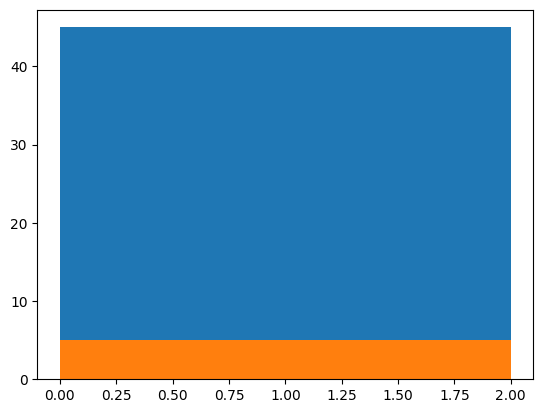

In [183]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

# Разработка архитектуры сети

In [203]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,      # форма входных данных модели
                            epochs=200,    # количество эпох обучения
                            batch_size=5  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 256)               9728      
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_29 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_30 (Ba  (None, 128)               512       
 tchNormalization)                                    

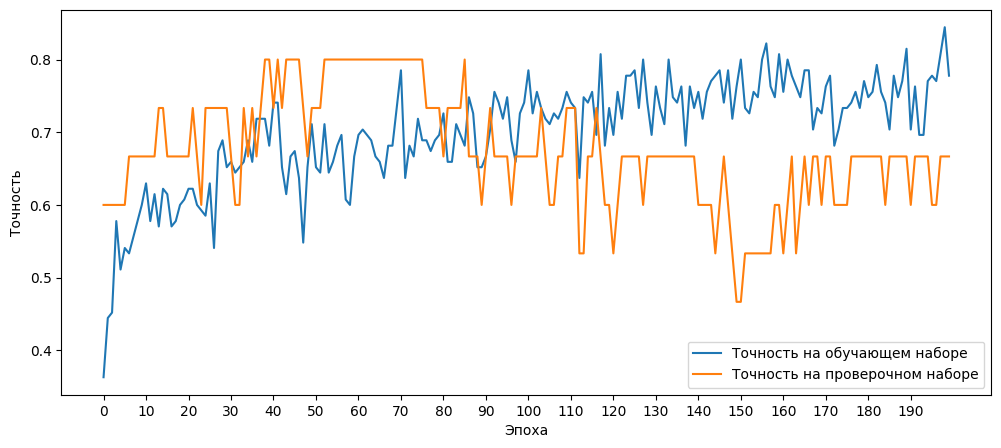

In [204]:
model = create_train_classifier(x_train.shape[1:])

In [205]:
# Сохранение/восстановление модели и выборок

model.save('/content/model_audio_mean.h5')
with open('/content/audio_train_val_mean.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

model = load_model('/content/model_audio_mean.h5')
with open('/content/audio_train_val_mean.pickle', 'rb') as f:
    x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

# Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

In [188]:
# Формирование тестовой выборки из файлов, не вошедших в основной набор

x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)
x_test = x_scaler.transform(x_test)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


KeyboardInterrupt: ignored

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

###Визуализация на файлах тренировочного набора

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler, 50, 5)

###Визуализация на файлах тренировочного набора

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 95, 5)

##Методика подбора значимых параметров для обучения модели

In [ ]:
# Функция создания и обучения упрощенной архитектуры классификатора

def create_train_small_classifier(index_list,       # список номеров признаков в списке
                                  x_train=x_train,  # обучающая выборка - вход
                                  y_train=y_train,  # обучающая выборка - выход
                                  x_val=x_val,      # проверочная выборка - вход
                                  y_val=y_val,      # проверочная выборка - выход
                                  epochs=120,       # количество эпох обучения
                                  batch_size=20,    # размер батча
                                  verbose=0         # подробность вывода при обучении
                                  ):
    # Сборка модели
    model = Sequential()
    model.add(Dense(200, activation='elu', input_shape=(len(index_list),)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение модели на подмножестве признаков
    history = model.fit(x_train[:, index_list],
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_data=(x_val[:, index_list], y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    print('Точность в конце обучения:',
          history.history['accuracy'][-1],
          history.history['val_accuracy'][-1])

    return model

In [ ]:
# Обучение малой модели: все параметры
model_small = create_train_small_classifier(range(0, 37))

In [ ]:
# Обучение малой модели: все параметры кроме мел-коэффициентов и хромаграммы
model_small = create_train_small_classifier(range(0, 5))

In [ ]:
# Обучение малой модели: только мел-коэффициенты
model_small = create_train_small_classifier(range(5, 25))

In [ ]:
# Обучение малой модели: только хромаграмма
model_small = create_train_small_classifier(range(25, 37))

In [ ]:
# Обучение малой модели: мел-коэффициенты и хромаграмма
model_small = create_train_small_classifier(range(5, 37))

In [ ]:
# Обучение малой модели: все параметры кроме хромаграммы
model_small = create_train_small_classifier(range(0, 25))

In [ ]:
# Обучение малой модели: все параметры с шагом 2
model_small = create_train_small_classifier(range(0, 37, 2))